# Where to install new Velib' rental station in Paris

## I. Install and import all the needed libraries

In [1]:
!pip install panda
!pip install folium=0.5.0 --yes
!pip install geopy --yes 
!pip install descartes
!pip install numba --prefer-binary
!pip install contextily
!pip install git+git://github.com/geopandas/geopandas.git
!pip install fastparquet
!pip install pyarrow

  Stored in directory: /home/jupyterlab/.cache/pip/wheels/c6/c8/45/06ed898b0bb401c1ff207dbb05b1587ff28860a236d98b1996
Successfully built panda

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --yes

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --yes
     |████████████████████████████████| 2.6MB 9.0MB/s eta 0:00:01
     |████████████████████████████████| 18.3MB 427kB/s eta 0:00:011     |████████████████████▉           | 11.9MB 5.5

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import json,urllib.request
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.wkt import loads as load_wkt
import branca
from branca.colormap import linear
import branca.colormap as cm

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


## II. Import all the data from the internet

In order to save some times during the working phase, I extracted all the data from the internet and save them in local files. 

Download from the internet the set of data related to all rental stations in Paris

In [3]:
#extract the data from internet

url_station='https://velib-metropole-opendata.smoove.pro/opendata/Velib_Metropole/station_information.json'

#extract the data in a dataframe

station = requests.get(url_station).json()
station_df = pd.json_normalize(data = station['data'], 
                           record_path ='stations',  
                           errors='ignore',
                           record_prefix='_')

#Save the dataframe in a parquet file

station_df.to_parquet('station_df.parquet.gzip',
              compression='gzip')  

Download from the internet the set of data related to all the cycle paths in Paris

In [ ]:
#extract the data from internet

url_path='https://opendata.paris.fr/explore/dataset/reseau-cyclable/download/?format=geojson&timezone=Europe/Berlin&lang=fr'
path = requests.get(url_path).json()

#extract the data in a dataframe
path_df=pd.json_normalize(data=path['features']) 

#Take only the columns which we want in a new dataframe
path_coord_df_raw=path_df[['properties.geo_point_2d','properties.length']]
path_coord_df_raw['lat'] = path_coord_df_raw['properties.geo_point_2d'].str[:1].str.get(0)
path_coord_df_raw['lon'] = path_coord_df_raw['properties.geo_point_2d'].str[1:].str.get(0)


Clean and adjust to the need the set of data related to the cycle path

In [ ]:
#extract the data from a shp file downloaded manually from internet regarding the borough

link=r'quartier_paris.shp'
quartiers = gpd.read_file(link)

#Get the dataframe saved in the previous step
path_coord_df_work=path_coord_df_raw

#Use Geopandas to obtain from lat and long the geometry in 2D
path_coord_df_work = gpd.GeoDataFrame(
    path_coord_df_work, geometry=gpd.points_from_xy(path_coord_df_work.lon, path_coord_df_work.lat))

#Give for each cycle path its borough (using the borough coordinates)

path_coord_df_work['quartier']=""

for ind in path_coord_df_work.index:
    p1=path_coord_df_work['geometry'][ind]
    for index,quartier in quartiers.iterrows():
        poly=quartier['geometry']
        if poly.contains(p1):
            path_coord_df_work['quartier'][ind]=quartier['c_qu']

#Group the database of the bicycle path by borough, and sum the lenght of paths
cycle_path_by_borough = path_coord_df_work.groupby('quartier')['properties.length'].sum().to_frame().reset_index()
cycle_path_by_borough['quartier']=cycle_path_by_borough.quartier.replace('',np.nan).astype(float)

#Rename the columns
cycle_path_by_borough.rename(columns={"quartier": "c_qu"})


#Concatenate the DF of the borough and the one of the cycle paths cleaned, rename teh columns
cycle_path_by_borough = pd.concat([cycle_path_by_borough, quartiers], axis=1, keys='c_qu')
cycle_path_by_borough.columns = ['quartier', 'lenght','n_sq_qu','c_qu','c_quinsee','l_qu','c_ar','n_sq_ar','perimeter','surface','geometry'] 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:

#Add a column to calculate the number of km of cycle path per km2 for each borough
cycle_path_by_borough['lenghtskm_per_km2']=cycle_path_by_borough[('lenght')]/cycle_path_by_borough['surface']*1000

In [ ]:
#Drop uneeded columns
cycle_path_by_borough=cycle_path_by_borough.drop(['l_qu', 'geometry'], axis = 1)


In [ ]:
#Save the dataframe in a parquet file
cycle_path_by_borough.to_parquet('cycle_path_by_borough.parquet.gzip',
              compression='gzip')

In [ ]:
cycle_path_by_borough

## III. Import the different datasets from the local files previously saved

1. Import the data from the Velib' rental station and put them in a dataframe

In [3]:
station_df=pd.read_parquet(r'station_df.parquet.gzip', engine='fastparquet')
station_df.head()

_station_id                                _name       _lat      _lon  \
0    213688169        Benjamin Godard - Victor Hugo  48.865983  2.275725   
1     99950133   André Mazet - Saint-André des Arts  48.853756  2.339096   
2    516709288  Charonne - Robert et Sonia Delauney  48.855908  2.392571   
3        36255                   Toudouze - Clauzel  48.879296  2.337360   
4     37815204                      Mairie du 12ème  48.840855  2.387555   

   _capacity _stationCode _rental_methods  
0         35        16107            None  
1         55         6015    [CREDITCARD]  
2         20        11104            None  
3         21         9020    [CREDITCARD]  
4         30        12109            None

2. Import the datas of the 80 boroughs of Paris

In [4]:
link=r'quartier_paris.shp'
quartiers = gpd.read_file(link,encoding='utf-8')
df_quart = quartiers.to_crs(epsg=3857)
quartiers

n_sq_qu  c_qu  c_quinsee            l_qu  c_ar      n_sq_ar  \
0   750000007.0   7.0  7510203.0            Mail   2.0  750000002.0   
1   750000008.0   8.0  7510204.0  Bonne-Nouvelle   2.0  750000002.0   
2   750000050.0  50.0  7511302.0            Gare  13.0  750000013.0   
3   750000070.0  70.0  7511802.0    Clignancourt  18.0  750000018.0   
4   750000071.0  71.0  7511803.0     Goutte-d'Or  18.0  750000018.0   
..          ...   ...        ...             ...   ...          ...   
75  750000021.0  21.0  7510601.0         Monnaie   6.0  750000006.0   
76  750000022.0  22.0  7510602.0           Odéon   6.0  750000006.0   
77  750000029.0  29.0  7510801.0  Champs-Elysées   8.0  750000008.0   
78  750000051.0  51.0  7511303.0  Maison-Blanche  13.0  750000013.0   
79  750000052.0  52.0  7511304.0     Croulebarbe  13.0  750000013.0   

      perimetre       surface  \
0   2179.153605  2.781426e+05   
1   2233.976030  2.814482e+05   
2   7070.350567  3.044178e+06   
3   6005.520389  1.653715e+06   
4   5176.406895  1.089226e+06   
..          ...           ...   
75  2391.122818  2.933606e+05   
76  3516.314464  7.161484e+05   
77  5480.652870  1.140254e+06   
78  6814.373288  2.231506e+06   
79  3289.230480  6.920677e+05   

                                             geometry  
0   POLYGON ((2.34684 48.86491, 2.34668 48.86443, ...  
1   POLYGON ((2.35152 48.86443, 2.35095 48.86341, ...  
2   POLYGON ((2.36771 48.81742, 2.36696 48.81719, ...  
3   POLYGON ((2.35168 48.89139, 2.35145 48.89043, ...  
4   POLYGON ((2.34967 48.88374, 2.34951 48.88373, ...  
..                                                ...  
75  POLYGON ((2.34317 48.85139, 2.34268 48.85036, ...  
76  POLYGON ((2.33699 48.85290, 2.33894 48.85242, ...  
77  POLYGON ((2.30646 48.87015, 2.31011 48.86898, ...  
78  POLYGON ((2.34912 48.82960, 2.34954 48.82955, ...  
79  POLYGON ((2.35166 48.83678, 2.35176 48.83678, ...  

[80 rows x 9 columns]

In [5]:
cen = []

for centroid in quartiers.index:
    cen.append(quartiers['geometry'][centroid].centroid)

quartiers['centroid'] = cen

quartiers

n_sq_qu  c_qu  c_quinsee            l_qu  c_ar      n_sq_ar  \
0   750000007.0   7.0  7510203.0            Mail   2.0  750000002.0   
1   750000008.0   8.0  7510204.0  Bonne-Nouvelle   2.0  750000002.0   
2   750000050.0  50.0  7511302.0            Gare  13.0  750000013.0   
3   750000070.0  70.0  7511802.0    Clignancourt  18.0  750000018.0   
4   750000071.0  71.0  7511803.0     Goutte-d'Or  18.0  750000018.0   
..          ...   ...        ...             ...   ...          ...   
75  750000021.0  21.0  7510601.0         Monnaie   6.0  750000006.0   
76  750000022.0  22.0  7510602.0           Odéon   6.0  750000006.0   
77  750000029.0  29.0  7510801.0  Champs-Elysées   8.0  750000008.0   
78  750000051.0  51.0  7511303.0  Maison-Blanche  13.0  750000013.0   
79  750000052.0  52.0  7511304.0     Croulebarbe  13.0  750000013.0   

      perimetre       surface  \
0   2179.153605  2.781426e+05   
1   2233.976030  2.814482e+05   
2   7070.350567  3.044178e+06   
3   6005.520389  1.653715e+06   
4   5176.406895  1.089226e+06   
..          ...           ...   
75  2391.122818  2.933606e+05   
76  3516.314464  7.161484e+05   
77  5480.652870  1.140254e+06   
78  6814.373288  2.231506e+06   
79  3289.230480  6.920677e+05   

                                             geometry  \
0   POLYGON ((2.34684 48.86491, 2.34668 48.86443, ...   
1   POLYGON ((2.35152 48.86443, 2.35095 48.86341, ...   
2   POLYGON ((2.36771 48.81742, 2.36696 48.81719, ...   
3   POLYGON ((2.35168 48.89139, 2.35145 48.89043, ...   
4   POLYGON ((2.34967 48.88374, 2.34951 48.88373, ...   
..                                                ...   
75  POLYGON ((2.34317 48.85139, 2.34268 48.85036, ...   
76  POLYGON ((2.33699 48.85290, 2.33894 48.85242, ...   
77  POLYGON ((2.30646 48.87015, 2.31011 48.86898, ...   
78  POLYGON ((2.34912 48.82960, 2.34954 48.82955, ...   
79  POLYGON ((2.35166 48.83678, 2.35176 48.83678, ...   

                                       centroid  
0   POINT (2.344699127427459 48.86800833740273)  
1    POINT (2.350080190408817 48.8671501183107)  
2   POINT (2.372397736918937 48.82752745777261)  
3   POINT (2.345978754593187 48.89166759106754)  
4   POINT (2.355536163296277 48.89213818760239)  
..                                          ...  
75  POINT (2.340035371130516 48.85438440363995)  
76  POINT (2.336338827587675 48.84780062929266)  
77  POINT (2.308651684681398 48.86707449218532)  
78  POINT (2.352433149542819 48.82312780567428)  
79  POINT (2.347673046065808 48.83373367612221)  

[80 rows x 10 columns]

Add for each borough the centroid of it and its coordinates

In [6]:
lat = []
lon = []

for index in quartiers.index:
    lat.append(quartiers['centroid'][index].y)
    lon.append(quartiers['centroid'][index].x)

quartiers['lat'] = lat
quartiers['lon'] = lon

quartiers

n_sq_qu  c_qu  c_quinsee            l_qu  c_ar      n_sq_ar  \
0   750000007.0   7.0  7510203.0            Mail   2.0  750000002.0   
1   750000008.0   8.0  7510204.0  Bonne-Nouvelle   2.0  750000002.0   
2   750000050.0  50.0  7511302.0            Gare  13.0  750000013.0   
3   750000070.0  70.0  7511802.0    Clignancourt  18.0  750000018.0   
4   750000071.0  71.0  7511803.0     Goutte-d'Or  18.0  750000018.0   
..          ...   ...        ...             ...   ...          ...   
75  750000021.0  21.0  7510601.0         Monnaie   6.0  750000006.0   
76  750000022.0  22.0  7510602.0           Odéon   6.0  750000006.0   
77  750000029.0  29.0  7510801.0  Champs-Elysées   8.0  750000008.0   
78  750000051.0  51.0  7511303.0  Maison-Blanche  13.0  750000013.0   
79  750000052.0  52.0  7511304.0     Croulebarbe  13.0  750000013.0   

      perimetre       surface  \
0   2179.153605  2.781426e+05   
1   2233.976030  2.814482e+05   
2   7070.350567  3.044178e+06   
3   6005.520389  1.653715e+06   
4   5176.406895  1.089226e+06   
..          ...           ...   
75  2391.122818  2.933606e+05   
76  3516.314464  7.161484e+05   
77  5480.652870  1.140254e+06   
78  6814.373288  2.231506e+06   
79  3289.230480  6.920677e+05   

                                             geometry  \
0   POLYGON ((2.34684 48.86491, 2.34668 48.86443, ...   
1   POLYGON ((2.35152 48.86443, 2.35095 48.86341, ...   
2   POLYGON ((2.36771 48.81742, 2.36696 48.81719, ...   
3   POLYGON ((2.35168 48.89139, 2.35145 48.89043, ...   
4   POLYGON ((2.34967 48.88374, 2.34951 48.88373, ...   
..                                                ...   
75  POLYGON ((2.34317 48.85139, 2.34268 48.85036, ...   
76  POLYGON ((2.33699 48.85290, 2.33894 48.85242, ...   
77  POLYGON ((2.30646 48.87015, 2.31011 48.86898, ...   
78  POLYGON ((2.34912 48.82960, 2.34954 48.82955, ...   
79  POLYGON ((2.35166 48.83678, 2.35176 48.83678, ...   

                                       centroid        lat       lon  
0   POINT (2.344699127427459 48.86800833740273)  48.868008  2.344699  
1    POINT (2.350080190408817 48.8671501183107)  48.867150  2.350080  
2   POINT (2.372397736918937 48.82752745777261)  48.827527  2.372398  
3   POINT (2.345978754593187 48.89166759106754)  48.891668  2.345979  
4   POINT (2.355536163296277 48.89213818760239)  48.892138  2.355536  
..                                          ...        ...       ...  
75  POINT (2.340035371130516 48.85438440363995)  48.854384  2.340035  
76  POINT (2.336338827587675 48.84780062929266)  48.847801  2.336339  
77  POINT (2.308651684681398 48.86707449218532)  48.867074  2.308652  
78  POINT (2.352433149542819 48.82312780567428)  48.823128  2.352433  
79  POINT (2.347673046065808 48.83373367612221)  48.833734  2.347673  

[80 rows x 12 columns]

In [7]:
quartiers['radius']=quartiers[('perimetre')]/6.28
quartiers


n_sq_qu  c_qu  c_quinsee            l_qu  c_ar      n_sq_ar  \
0   750000007.0   7.0  7510203.0            Mail   2.0  750000002.0   
1   750000008.0   8.0  7510204.0  Bonne-Nouvelle   2.0  750000002.0   
2   750000050.0  50.0  7511302.0            Gare  13.0  750000013.0   
3   750000070.0  70.0  7511802.0    Clignancourt  18.0  750000018.0   
4   750000071.0  71.0  7511803.0     Goutte-d'Or  18.0  750000018.0   
..          ...   ...        ...             ...   ...          ...   
75  750000021.0  21.0  7510601.0         Monnaie   6.0  750000006.0   
76  750000022.0  22.0  7510602.0           Odéon   6.0  750000006.0   
77  750000029.0  29.0  7510801.0  Champs-Elysées   8.0  750000008.0   
78  750000051.0  51.0  7511303.0  Maison-Blanche  13.0  750000013.0   
79  750000052.0  52.0  7511304.0     Croulebarbe  13.0  750000013.0   

      perimetre       surface  \
0   2179.153605  2.781426e+05   
1   2233.976030  2.814482e+05   
2   7070.350567  3.044178e+06   
3   6005.520389  1.653715e+06   
4   5176.406895  1.089226e+06   
..          ...           ...   
75  2391.122818  2.933606e+05   
76  3516.314464  7.161484e+05   
77  5480.652870  1.140254e+06   
78  6814.373288  2.231506e+06   
79  3289.230480  6.920677e+05   

                                             geometry  \
0   POLYGON ((2.34684 48.86491, 2.34668 48.86443, ...   
1   POLYGON ((2.35152 48.86443, 2.35095 48.86341, ...   
2   POLYGON ((2.36771 48.81742, 2.36696 48.81719, ...   
3   POLYGON ((2.35168 48.89139, 2.35145 48.89043, ...   
4   POLYGON ((2.34967 48.88374, 2.34951 48.88373, ...   
..                                                ...   
75  POLYGON ((2.34317 48.85139, 2.34268 48.85036, ...   
76  POLYGON ((2.33699 48.85290, 2.33894 48.85242, ...   
77  POLYGON ((2.30646 48.87015, 2.31011 48.86898, ...   
78  POLYGON ((2.34912 48.82960, 2.34954 48.82955, ...   
79  POLYGON ((2.35166 48.83678, 2.35176 48.83678, ...   

                                       centroid        lat       lon  \
0   POINT (2.344699127427459 48.86800833740273)  48.868008  2.344699   
1    POINT (2.350080190408817 48.8671501183107)  48.867150  2.350080   
2   POINT (2.372397736918937 48.82752745777261)  48.827527  2.372398   
3   POINT (2.345978754593187 48.89166759106754)  48.891668  2.345979   
4   POINT (2.355536163296277 48.89213818760239)  48.892138  2.355536   
..                                          ...        ...       ...   
75  POINT (2.340035371130516 48.85438440363995)  48.854384  2.340035   
76  POINT (2.336338827587675 48.84780062929266)  48.847801  2.336339   
77  POINT (2.308651684681398 48.86707449218532)  48.867074  2.308652   
78  POINT (2.352433149542819 48.82312780567428)  48.823128  2.352433   
79  POINT (2.347673046065808 48.83373367612221)  48.833734  2.347673   

         radius  
0    346.998982  
1    355.728667  
2   1125.852001  
3    956.293056  
4    824.268614  
..          ...  
75   380.752041  
76   559.922685  
77   872.715425  
78  1085.091288  
79   523.762815  

[80 rows x 13 columns]

Display the boroughs on a map

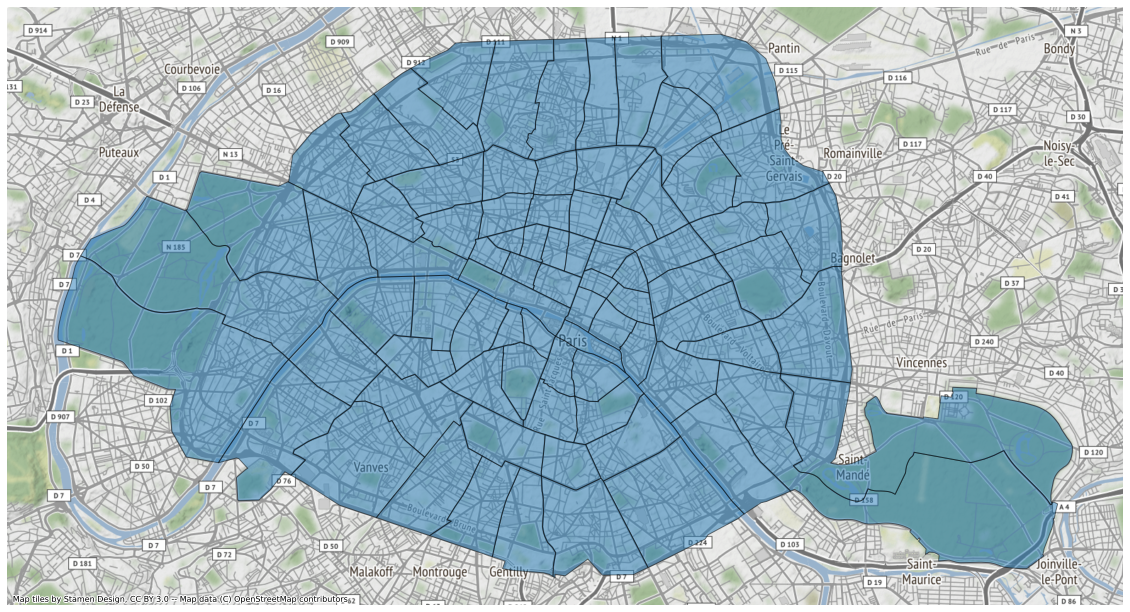

In [8]:
ax = df_quart.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)
ax.set_axis_off()

3. Import the data from cycle pathes and put them in a dataframe

In [9]:
cycle_path_by_borough=pd.read_parquet('cycle_path_by_borough.parquet.gzip', engine='fastparquet')


Get the coordinates of Paris

In [10]:
address = 'Paris, FR'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print(latitude, longitude)

48.8566969 2.3514616


In [11]:
df_quart=df_quart.rename(columns={"c_qu": "quartier"})



In [12]:
# generate choropleth map
map_paris = folium.Map(location=[latitude, longitude], zoom_start=12)

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(cycle_path_by_borough['lenghtskm_per_km2'].min(),
                              cycle_path_by_borough['lenghtskm_per_km2'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

threshold_scale

map_paris.choropleth(
    geo_data=df_quart,
    data=cycle_path_by_borough,
    columns=['quartier', 'lenghtskm_per_km2'],
    key_on='feature.properties.quartier',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.65, 
    line_opacity=0.2,
    legend_name='Cycle paths in Paris',
    reset=True
)

# display map
map_paris

4. Import the data from station utilization

In [13]:
stations_utilization = pd.read_parquet("frame_data.bin")

## IV. Foursquare API

Define Foursquare Credentials and Version

In [14]:
offices='4d4b7105d754a06375d81259'

In [15]:
CLIENT_ID = '5TWIHQMPAJDY0ZQV1QN15DBNTZKXJQ4YVCF5IUSKU31WXGSF' # your Foursquare ID
CLIENT_SECRET = 'RSVQWSO1XSFHALFBKUCNJU0ILIPYWH0RCH4ZEGSUZ5OEUGDU' # your Foursquare Secret
VERSION = '20200101'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5TWIHQMPAJDY0ZQV1QN15DBNTZKXJQ4YVCF5IUSKU31WXGSF
CLIENT_SECRET:RSVQWSO1XSFHALFBKUCNJU0ILIPYWH0RCH4ZEGSUZ5OEUGDU


Define few functions usefull to extract data from Foursquare APi

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius, categoryId):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radius):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

Create the database with the Foursquare API info for Office category and save it locally

In [19]:
paris_venues_office = getNearbyVenues(names=quartiers['c_qu'],
                                   latitudes=quartiers['lat'],
                                   longitudes=quartiers['lon'],
                                   radius=quartiers['radius'],
                                   categoryId=offices
                                  )


paris_venues_office.columns = ['quartier', 'lat','lon','venue','ven_lat','ven_lon','cat'] 


#Save the dataframe in a parquet file
paris_venues_office.to_parquet('paris_venues_offices.parquet.gzip',
              compression='gzip')



Plug from local file the database of Foursquare API info

In [14]:
paris_venues_offices=pd.read_parquet(r'paris_venues_offices.parquet.gzip', engine='fastparquet')


Display the heatmap with Office API and Velib rental station

In [15]:
venues_map_offices = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel


from folium.plugins import HeatMap
paris_venues_offices['count'] = 1
HeatMap(data=paris_venues_offices[['ven_lat', 'ven_lon', 'count']].groupby(['ven_lat', 'ven_lon']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(venues_map_offices)

# add markers to map
for lat, lng, label in zip(station_df['_lat'], station_df['_lon'], station_df['_name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='#0E07BC',
        fill=True,
        fill_color='#0E07BC',
        fill_opacity=0.7,
        parse_html=False).add_to(venues_map_offices)  
    
venues_map_offices



In [16]:
venues_map_offices = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel


from folium.plugins import HeatMap
paris_venues_offices['count'] = 1
HeatMap(data=paris_venues_offices[['ven_lat', 'ven_lon', 'count']].groupby(['ven_lat', 'ven_lon']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(venues_map_offices)

    
venues_map_offices

Display all the stations on a map

In [17]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(station_df['_lat'], station_df['_lon'], station_df['_name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='#0E07BC',
        fill=True,
        fill_color='#0E07BC',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

## V. Discussion

Display the map of the stations with the 'Working station coefficient"

Create the color scale

In [19]:
f=lambda x: np.arctan(x/0.15*1.07)
station_geo2 = []

convertion = lambda x: [float(x) for x in  x[0].split(',')]
stations_utilization['station_geo2'] = stations_utilization['station_geo'].apply(convertion)

lat = []
lon = []

for index in stations_utilization.index:
    lat.append(stations_utilization['station_geo2'][index][0])
    lon.append(stations_utilization['station_geo2'][index][1])
    
stations_utilization['lat'] = lat
stations_utilization['lon'] = lon

#Use Geopandas to obtain from lat and long the geometry in 2D
stations_utilization = gpd.GeoDataFrame(
    stations_utilization, geometry=gpd.points_from_xy(stations_utilization.lon, stations_utilization.lat))


In [21]:
colormap = cm.LinearColormap(colors=['maroon','gold'],index=[stations_utilization.total_usage.min(),stations_utilization.total_usage.max()],vmin=stations_utilization.total_usage.min(),vmax=stations_utilization.total_usage.max())

# create map of Paris using latitude and longitude values
map_paris_stations_rates = folium.Map(location=[latitude, longitude], zoom_start=12, tiles="Stamen Toner")


# add markers to map
for lat, lng, u in zip(stations_utilization['lat'], stations_utilization['lon'], stations_utilization['total_usage']):
    folium.Circle(
        [lat, lng],
        radius=60,
        color=colormap(f(u)),
        fill=True,
        fill_color=colormap(f(u)),
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris_stations_rates)  
    

map_paris_stations_rates.add_child(colormap)